<a href="https://colab.research.google.com/github/nagamamo/international_finance/blob/main/8_purchacing_power_parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

8　購買力平価モデルによる為替レートの予測

8.1 汎用ライブラリの読み込み

　本例では、IMFのInterantional Financial Statisticsの四半期データを用い、購買力平価モデルの理論実装例を示します。まず汎用ライブラリとして、pandas、numpy、datetime、matplotlibを読み込みます。

In [1]:
#[1]汎用ライブラリの読み込み
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import io
import requests

8.2　単位根検定ライブラリの読み込み

　購買力平価モデルを用いる際にも、単位根検定を行った上で、実装しなければなりません。単位根検定を実施するためのライブラリは下記をインポートします。

In [2]:
#[2]時系列データ検定ライブラリの読み込み
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller #ADF検定用ライブラリ

8.3　機械学習用ライブラリの読み込み

　機械学習用のライブラリをインポートします。本例では、sklearnを用いて機械学習による実証モデルの性能評価を行い、予測値を算出します。インポートするライブラリには、最小二乗法を行うためのライブラリ、データを学習データとテストデータに分割するライブラリ、決定係数と平均二乗誤差から機械学習評価を行う2つのライブラリの計4つのライブラリをインポートします。

In [3]:
#[3]機械学習用ライブラリの読み込み
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #学習・テストデータ分割のライブラリ
from sklearn.metrics import r2_score #決定係数による評価ライブラリ
from sklearn.metrics import mean_squared_error #平均二乗誤差による評価ライブラリ

8.4　IMF International Fianncial Statisticsから四半期データの取得

　外国為替レート、日米消費者物価指数の1980年代からの四半期データを取得します。尚、本リポジトリを使用される方は、クロスサイトスクリプティング等によりデータが破損することが今後ありうるため、IMFの下記のサイトからご自分でバルクデータを入手してら読み込んでください。
https://data.imf.org/?sk=4c514d48-b6ba-49ed-8ab9-52b0c1a0179b

In [ ]:
#[4]データの読み込み(URLから)
URL = "https://drive.google.com/uc?id=1zTfo-C0QCpcP4h3VR55i36Ch8zLZKdVu"
r = requests.get(URL)
ifs = pd.read_csv(io.BytesIO(r.content),index_col=0)
ifs.head()

8.5　分析対象国データの抽出

　一行目に国番号を入力することにより、購買力平価を算出したい国・地域のデータを抽出します。3～6行目はデータの整形のためのコードです。国番号は、8.4で読み込んだデータから確認してください。以下では日本を事例としてデータを抽出します。

In [ ]:
#[5]分析対象国データの抽出
country=pd.DataFrame(ifs[(ifs["Country Code"] == 158)]) #国・地域コードの入力箇所
country.reset_index(inplace=True) #インデックスのリセット
country.drop(country.columns[[0,1,2]],axis=1, inplace=True) #列の削除
country=country.T #行列の転置
country.columns = country.iloc[0] #新変数名（列）の定義
country = country.drop(country.index[0]) #行の削除
country.head() #データ確認

8.6　マクロ経済データの絞り込み

　抽出した国・地域データから、購買力平価の算出に必要なデータ、対USドル為替レート（ENDA_XDC_USD_RATE）、消費者物価上昇率（前年同期比、PCPI_PC_CP_A_PT）のみを抽出します。

In [ ]:
#[6]為替レートとインフレ率データの抽出と前処理
country2=country[['ENDA_XDC_USD_RATE','PCPI_PC_CP_A_PT']]
country2.columns = ['col0', 'col1']
country3=country2.rename(columns={'col0':'JPY_USD','col1':'CPI_JP'})
country4=country3.dropna() #欠損値を含む行の削除
country5=country4.drop('Attribute') #不要な行の削除
country5.head()

8.7　米国データの抽出

　本例では各国通貨の対USドルレートの購買力平価を算出するため、米国の消費者物価指数を取得します。対ユーロレートもしくはその他の通貨との間で購買力平価を算出する場合は、[7]をユーロ圏の消費者物価上昇率にしてください。米国データを絞り込んだ後、8.6で下準備した分析対象国データcountry5にこれを統合します。

In [ ]:
#[7]米国データの抽出
country=pd.DataFrame(ifs[(ifs["Country Code"] == 111)]) #米国カントリーコードの入力箇所
country.reset_index(inplace=True) #インデックスのリセット
country.drop(country.columns[[0,1,2]],axis=1, inplace=True) #列の削除
country=country.T #行列の転置
country.columns = country.iloc[0] #新変数名（列）の定義
country = country.drop(country.index[0]) #行の削除
country6=country[['PCPI_PC_CP_A_PT']]
country6.columns = ['col0']
country7=country6.rename(columns={'col0':'CPI_US'})
country8=country7.dropna() #欠損値を含む行の削除
country9=country8.drop('Attribute') #不要な行の削除
country5['CPI_US']=country9['CPI_US']
country5['JPY_USD'] =country5['JPY_USD'].astype('float') #数値データへの変換
country5['CPI_US'] =country5['CPI_US'].astype('float') #数値データへの変換
country5['CPI_JP'] =country5['CPI_JP'].astype('float') #数値データへの変換
country5['d_EX']=country5['JPY_USD'].pct_change()*100
country5['d_CPI']=country5['CPI_US']-country5['CPI_JP']
country5

8.8　データセットの下処理

　取得したデータから、ドル円レートの前月比（d_EX）、日米インフレ率格差（d_CPI）を算出してpandasデータフレームにそれぞれの新変数列を追加します。後者の日米インフレ率格差(d_CPI)が、購買力平価要因を表します。重ねて述べるように、sklearnではデータの入出力はnumpy配列を前提としていますので、pandasデータフレームのデータを「.value」により変換し、これをYとXとします。

In [ ]:
#[8]採用変数の算出と定義
country5=country5.dropna()#欠損値の除去
Y=country5['d_EX'].values #被説明変数の定義と配列変更
X=country5[['d_CPI']].values #説明変数の定義と配列変更
country5.head()

8.9　可視化

　データを可視化します。

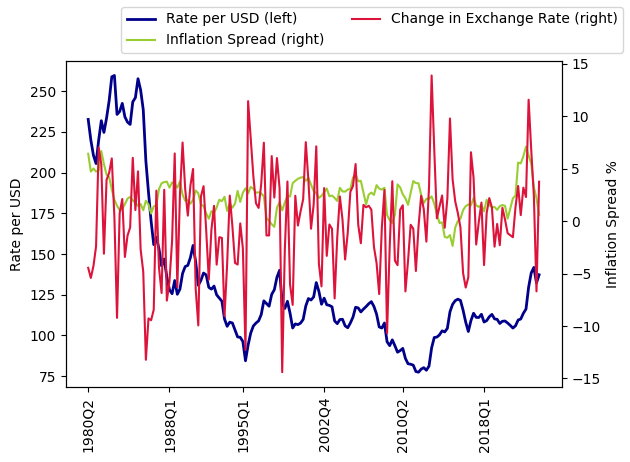

In [9]:
#[9]データの可視化
import matplotlib.dates as mdates
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax1.plot(country5['JPY_USD'], lw=2, color="darkblue",label="Rate per USD (left)")
ax2.plot(country5['d_CPI'], c="yellowgreen",label="Inflation Spread (right)")
ax2.plot(country5['d_EX'], c="crimson",label="Change in Exchange Rate (right)")
fig.autofmt_xdate(rotation=90, ha="center")
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.ylabel('Rate per USD')
ax1.set_ylabel('Rate per USD')
ax2.set_ylabel('Inflation Spread %')
fig.legend(ncol=2)
plt.show()

8.10　単位根検定

　時系列データを用いる場合、時間の経過とともにデータの平均値や分散が変化する単位根を持つか否かを確認した上で、分析を行う必要があります。その理由は、採用するデータがもし時間変化とともに確率分布が変化する非定常過程なのであれば、変数間に誤った関係が存在することを支持してしまう懸念があるためです。この点、データサイエンスでは、例えばある時点tとそれ以前のt-1もしくは更に過去のデータとの関係を示す自己回帰モデルを推計することで、時系列データの定常性（非定常性）を統計的に確認します。これが単位根検定と呼ばれる検定方法です。本例ではstatmodelsの拡張版Dickey=Fuller検定（ADF検定）によりデータの定常性を検定します。本例では、自己回帰モデルにトレンドは含めず、定数項のみと設定しています。
単位根検定の結果は、左から順にADF検定量、p値、検定に用いたラグ数、標本数、1%、5%、10%有意水準を示しています。

In [ ]:
#[10]時系列データの単位根検定
#sm.tsa.stattools.adfuller(Y, regression='c') #為替レート変化率の単位根検定
sm.tsa.stattools.adfuller(X, regression='c') #米日インフレ率格差の単位根検定

　データの定常性が確認されれば、データ数と説明変数の配列を念のため確認しておきます。

In [ ]:
#[11]データ数と配列の確認
ndarrayX = np.array(X)
ndarrayY = np.array(Y)
print("ndarrayX.shape:", ndarrayX.shape)
print("ndarrayY.shape:", ndarrayY.shape)

8.11　学習データとテストデータへの分割

　次にデータを学習データ(X_train、Y_train)とテストデータ（X_test、Y_test）に分割し、学習データにアセット・アプローチ・モデルをフィッティングします。[9]１行目のコードは、学習データとテストデータを、ランダムに70％：30％に分割することを指示しています。2行目のコードで推計に最小二乗法を採用し、3行目において学習データを用いてフィッティングを行います。4行目と5行目は、それぞれ学習データとテストデータを用いた為替レート（変化率）の予測値を算出します。この学習データとテストデータの予測値を比較することで、この実証モデルの性能を評価します。

In [13]:
#[12]購買力平価モデルの推計と機械学習
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)#学習データとテストデータの分割
model=LinearRegression(fit_intercept=True,copy_X=True,n_jobs=1,positive=False)#推計方法の定義
model.fit(X_train,Y_train)#フィッティング
Y_train_pred=model.predict(X_train)#学習データによる予測値の算出
Y_test_pred=model.predict(X_test)#テストデータによる予測値の算出

8.12　フィッティングと推計結果の出力

推計結果を出力します。

In [14]:
#[13]推計結果と可視化
print('d_CPI: %.4f' % model.coef_[0])#係数値
print('R2: %.4f' %model.score(X_train,Y_train))#決定係数

d_CPI: 0.2944
R2: 0.0103


In [ ]:
#[14]データ数と配列の確認
ndarrayX_train = np.array(X_train)
ndarrayY_train= np.array(Y_train)
ndarrayY_train_pred= np.array(Y_train_pred)
print("ndarrayX_train.shape:", ndarrayX_train.shape)
print("ndarrayY_train.shape:", ndarrayY_train.shape)
print("ndarrayY_train_pred.shape:", ndarrayY_train_pred.shape)

8.13　残差平方和と決定係数による評価

　学習データとテストデータの2つを用い、その実績値と予測値の違いが「似通っているか」を確認します。この学習データとテストデータの違いが小さければ、次のステップである「予測」に進みます。

In [ ]:
#[15]機械学習による評価
print('RMSE 学習: %.4f, テスト: %.4f' %(mean_squared_error(Y_train,Y_train_pred,squared=False),mean_squared_error(Y_test,Y_test_pred,squared=False)))#平方二乗誤差の評価
print('R2 学習: %.4f, テスト: %.4f' %(r2_score(Y_train,Y_train_pred),r2_score(Y_test,Y_test_pred)))#決定係数の評価

8.14　学習データとテストデータの残差平方和の可視化

　RMSEとR2により、購買力平価モデルの性能評価結果を確認すると、概ね学習データとテストデータからもたらされる値が接近していることがわかります。最後に、上記の結果を視覚的に確認するため、学習データとテストデータから算出された予測値と実績値との誤差をプロットします。

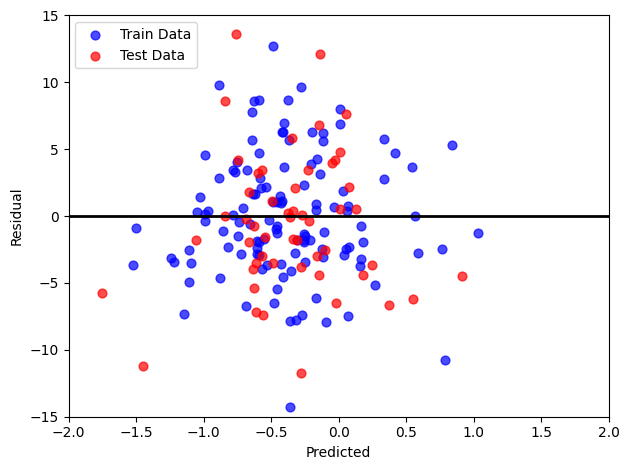

In [17]:
#[16]機械学習結果の可視化
plt.scatter(Y_train_pred,Y_train_pred-Y_train,c='blue',marker='o',s=40,alpha=0.7,label='Train Data')
plt.scatter(Y_test_pred,Y_test_pred-Y_test,c='red',marker='o',s=40,alpha=0.7,label='Test Data')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-2,xmax=2,lw=2,color='black')
plt.xlim([-2.0,2.0])
plt.ylim([-15,15])
plt.tight_layout()
plt.show()

8.15　購買力平価モデルによる為替レート予測k

　最後のセルは、将来のドル円レートを予測するコードです。それぞれlast_P（直近の米日インフレ率格差）、add_CPI（未来の米日インフレ率格差増加・縮小）を入力すれば、その「未来」時点でのドル円レートが計算されます。直近の値は、任意に与えても差し障りありません。

　本例では、為替レートと2カ国・地域の消費者物価上昇率の単位根検定を行った上で、予測モデルをソースコードで記述しています。ドル円レートで実施してみると、1％の米国インフレ率の上昇は、0円90銭程度の円高へ帰結する結果が算出されます。

In [18]:
#[17]ドル円レートの予測
#lastR=US_Japan.d_R[-1] #標本データ直近の米日金利差
lastP=country5.d_CPI[-1] #標本データ直近のインフレ率格差
#add_spread=1.0 #金利スプレッド拡大幅
add_CPI=1.0 #インフレ率格差拡大幅
spot=145.54 #直近ドル円レート
#senario_R=lastR+add_spread
senario_P=lastP+add_CPI
a=model.predict([[senario_P]])
spot*(1+a/100)

array([144.68715584])